In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from PIL import Image
import os
from tqdm import tqdm
from torch.utils.data import Subset,  ConcatDataset
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from torch.optim import Adam
import math
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Pad, Resize, Grayscale, RandomHorizontalFlip, RandomRotation
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.datasets import ImageFolder
import torch.nn.init as init

In [130]:
def tensor_to_image(t):
  return Image.fromarray(np.array(((t.squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

In [131]:
# Path to the dataset
dataset_path = './datasets'
# Specify the dataset to be used
dataset = 'CIFAR10'
batch_size = 128

if dataset == "CIFAR10":
    img_size = (32, 32, 3) 
elif dataset == "MNIST": 
    img_size = (32, 32, 1) 
elif dataset == "FLOWER": 
    img_size = (64, 64, 3) 

if dataset == 'MNIST':
    transform = Compose([
        ToTensor(),         
        Pad(2),             # Aggiunge 2 pixel di padding a ogni lato
    ])
elif dataset == 'CIFAR10':
    transform = Compose([
        ToTensor(),      
    ])
elif dataset == 'FLOWER':
    transform = Compose([
        Resize((32, 32)),
        ToTensor()          
    ])

# Load CIFAR10 or MNIST dataset based on the selected option
if dataset == 'CIFAR10':
    train_dataset = CIFAR10(dataset_path, transform=transform, train=True, download=True)
    test_dataset = CIFAR10(dataset_path, transform=transform, train=False, download=True)
elif dataset == 'MNIST':
    train_dataset = MNIST(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = MNIST(dataset_path, transform=transform, train=False, download=True)
elif dataset == 'FLOWER':
    train_dataset = ImageFolder(root=dataset_path + "/flower/train", transform=transform)
    test_dataset = ImageFolder(root=dataset_path + "/flower/test", transform=transform)

full_dataset = ConcatDataset([train_dataset, test_dataset])
data_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


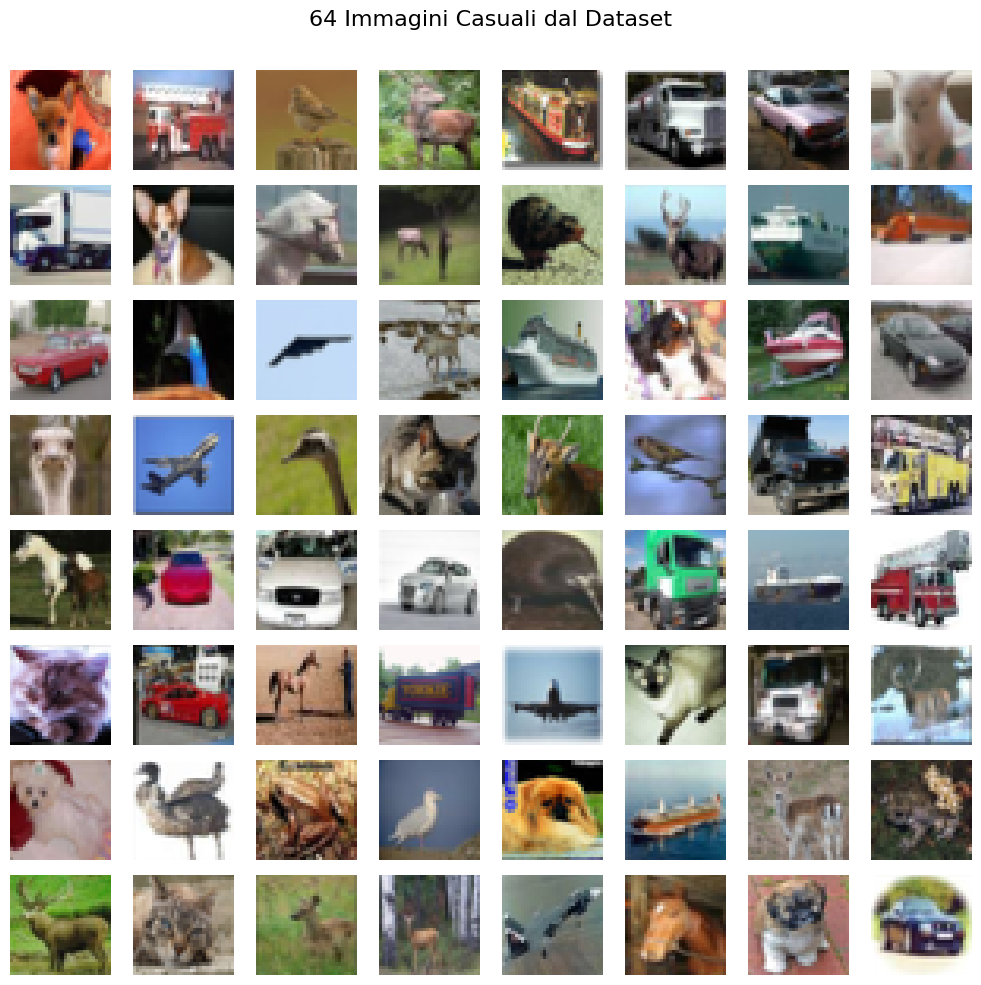

In [132]:
# Ottenere un batch di immagini casuali
images, labels = next(iter(data_loader))

# Configurare la griglia 8x8
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
fig.suptitle("64 Immagini Casuali dal Dataset", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(images):
        # Convertire il tensor dell'immagine in un formato visualizzabile
        img = images[i].permute(1, 2, 0).numpy()  # Cambiare dimensioni da (C, H, W) a (H, W, C)
        ax.imshow(img, interpolation='nearest')
        ax.axis('off')
    else:
        ax.axis('off')  # Nascondere gli assi per celle vuote

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


In [133]:
def get_time_embedding(time_steps, temb_dim):
    r"""
    Convert time steps tensor into an embedding using the
    sinusoidal time embedding formula
    :param time_steps: 1D tensor of length batch size
    :param temb_dim: Dimension of the embedding
    :return: BxD embedding representation of B time steps
    """
    assert temb_dim % 2 == 0, "time embedding dimension must be divisible by 2"
    
    # factor = 10000^(2i/d_model)
    factor = 10000 ** ((torch.arange(
        start=0, end=temb_dim // 2, dtype=torch.float32, device=time_steps.device) / (temb_dim // 2))
    )
    
    # pos / factor
    # timesteps B -> B, 1 -> B, temb_dim
    t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim,
                 down_sample=True, num_heads=4, num_layers=1, num_attention_blocks=1):
        super().__init__()
        self.num_layers = num_layers
        self.num_attention_blocks = num_attention_blocks  # Nuovo parametro
        self.down_sample = down_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
             for _ in range(num_attention_blocks)]  # Solo un numero limitato di blocchi
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
             for _ in range(num_attention_blocks)]  # Solo un numero limitato di blocchi
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels,
                                          4, 2, 1) if self.down_sample else nn.Identity()
    
    def forward(self, x, t_emb):
        out = x
        for i in range(self.num_layers):
            
            # Resnet block of Unet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            # Apply attention blocks only for `num_attention_blocks` times
            if i < self.num_attention_blocks:
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
            
        out = self.down_sample_conv(out)
        return out


class MidBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, num_layers=1, num_attention_blocks=1):
        super().__init__()
        self.num_layers = num_layers
        self.num_attention_blocks = num_attention_blocks  # Nuovo parametro
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers+1)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers + 1)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers+1)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
                for _ in range(num_attention_blocks)]  # Solo un numero limitato di blocchi
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_attention_blocks)]  # Solo un numero limitato di blocchi
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers+1)
            ]
        )
    
    def forward(self, x, t_emb):
        out = x
        
        # First resnet block
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)
        
        for i in range(self.num_layers):
            
            # Apply attention blocks only for `num_attention_blocks` times
            if i < self.num_attention_blocks:
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
            
            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i+1](out)
            out = out + self.t_emb_layers[i+1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i+1](out)
            out = out + self.residual_input_conv[i+1](resnet_input)
        
        return out


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample=True, num_heads=4, num_layers=1, num_attention_blocks=1):
        super().__init__()
        self.num_layers = num_layers
        self.num_attention_blocks = num_attention_blocks  # Nuovo parametro
        self.up_sample = up_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [
                nn.GroupNorm(8, out_channels)
                for _ in range(num_attention_blocks)  # Solo un numero limitato di blocchi
            ]
        )
        
        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_attention_blocks)  # Solo un numero limitato di blocchi
            ]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()
    
    def forward(self, x, out_down, t_emb):
        x = self.up_sample_conv(x)
        x = torch.cat([x, out_down], dim=1)
        
        out = x
        for i in range(self.num_layers):
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            # Apply attention blocks only for `num_attention_blocks` times
            if i < self.num_attention_blocks:
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn

        return out



class Unet(nn.Module):
    r"""
    Unet model comprising
    Down blocks, Midblocks and Uplocks
    """
    def __init__(self, model_config):
        super().__init__()
        im_channels = model_config['im_channels']
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.t_emb_dim = model_config['time_emb_dim']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']
        self.num_attention_blocks = model_config['num_attention_blocks']
        
        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-2]
        assert len(self.down_sample) == len(self.down_channels) - 1
        
        # Initial projection from sinusoidal time embedding
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=(1, 1))
        
        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels)-1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i+1], self.t_emb_dim,
                                        down_sample=self.down_sample[i], num_layers=self.num_down_layers, num_attention_blocks=self.num_attention_blocks))
        
        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels)-1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i+1], self.t_emb_dim,
                                      num_layers=self.num_mid_layers, num_attention_blocks=self.num_attention_blocks))
        
        self.ups = nn.ModuleList([])
        for i in reversed(range(len(self.down_channels)-1)):
            self.ups.append(UpBlock(self.down_channels[i] * 2, self.down_channels[i-1] if i != 0 else 16,
                                    self.t_emb_dim, up_sample=self.down_sample[i], num_layers=self.num_up_layers, num_attention_blocks=self.num_attention_blocks))
        
        self.norm_out = nn.GroupNorm(8, 16)
        self.conv_out = nn.Conv2d(16, im_channels, kernel_size=3, padding=1)
    
    def forward(self, x, t):
        # Shapes assuming downblocks are [C1, C2, C3, C4]
        # Shapes assuming midblocks are [C4, C4, C3]
        # Shapes assuming downsamples are [True, True, False]
        # B x C x H x W
        out = self.conv_in(x)
        # B x C1 x H x W
        
        # t_emb -> B x t_emb_dim
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        down_outs = []
        
        for idx, down in enumerate(self.downs):
            down_outs.append(out)
            out = down(out, t_emb)
        # down_outs  [B x C1 x H x W, B x C2 x H/2 x W/2, B x C3 x H/4 x W/4]
        # out B x C4 x H/4 x W/4
            
        for mid in self.mids:
            out = mid(out, t_emb)
        # out B x C3 x H/4 x W/4
        
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
            # out [B x C2 x H/4 x W/4, B x C1 x H/2 x W/2, B x 16 x H x W]
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        # out B x C x H x W
        return out


In [134]:
model_config = {
    'im_channels': img_size[2],            # RGB image input
    'down_channels': [64, 128, 128],  # Number of channels in downsampling layers
    'mid_channels': [128, 128],       # Midblock channels
    'time_emb_dim': 256,         # Time embedding dimension
    'down_sample': [True, True],  # Whether to downsample at each layer
    'num_down_layers': 2,        # Number of layers in downblock
    'num_mid_layers': 2,         # Number of layers in midblock
    'num_up_layers': 2,           # Number of layers in upblock
    'num_attention_blocks':0      
}

# Select the device based on GPU availability
if torch.cuda.is_available():
    device = 'cuda:1'  # Usa CUDA se disponibile
elif torch.backends.mps.is_available():
    device = 'mps'  # Usa MPS se disponibile
else:
    device = 'cpu'  # Fallback su CPU

print("Device: " + str(device))


Device: mps


In [135]:
# Set up some parameters
n_steps = 1000
beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_xt_x0(x0, t):
    n, c, h, w = x0.shape
    x0 = x0.to(device)
    eps = torch.randn(n, c, h, w).to(device)

    a_bar = alpha_bar[t]

    noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eps
    return noisy, eps 

In [136]:
# Create the model
model = Unet(model_config).to(device)

batch_size = 128 # Lower this if hitting memory issues
lr = 7e-5 # Explore this - might want it lower when training on the full dataset

losses = [] # Store losses for later plotting

optim = torch.optim.Adam(model.parameters(), lr=lr) # Optimizer

In [137]:
epochs = 50
epoch_loss = []

for epoch in tqdm(range(1, epochs + 1)):
    average_train_loss = 0
    loop_train = tqdm(enumerate(data_loader, 1), total=len(data_loader), desc="Train", position=0, leave=True)
    for index, (x0, label) in loop_train:
      x0 = x0.to(device)
      optim.zero_grad()
      t = torch.randint(0, n_steps, (x0.shape[0],), dtype=torch.long).to(device)
      xt, noise = q_xt_x0(x0, t)
      pred_noise = model(xt.float(), t)
      loss = F.mse_loss(noise.float(), pred_noise)
      losses.append(loss.item())
      average_train_loss+=loss.item()

      loss.backward()
      optim.step()

      loop_train.set_description(f"Train - iteration : {epoch}")
      loop_train.set_postfix(
          avg_train_loss="{:.4f}".format(average_train_loss / index),
          refresh=True,
      )
    epoch_loss.append(average_train_loss / len(data_loader))

torch.save(model.state_dict(), "./unit.pt")

  0%|          | 0/50 [00:07<?, ?it/s]


KeyboardInterrupt: 

## Iteration Loss

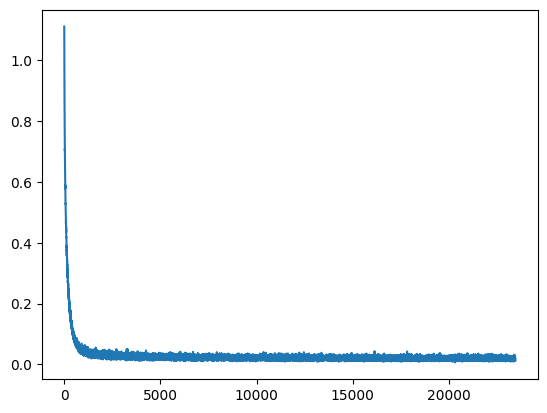

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)

## Epoch Loss

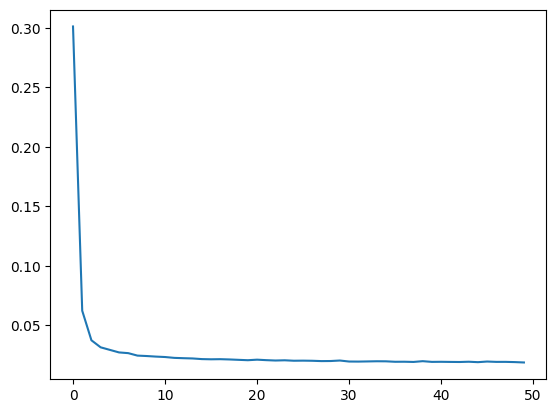

In [122]:
from matplotlib import pyplot as plt
plt.plot(epoch_loss)

In [123]:
def p_xt(xt, noise, t):
    alpha_t = alpha[t]
    alpha_bar_t = alpha_bar[t]
    eps_coef = (1 - alpha_t) / (1 - alpha_bar_t) ** .5
    mean = 1 / (alpha_t ** 0.5) * (xt - eps_coef * noise)
    var = beta[t]
    eps = torch.randn(xt.shape, device=device)
    return mean + (var ** 0.5) * eps


In [124]:
x = torch.randn(100, 3, 32, 32).to(device) # Start with random noise
ims = []
for i in range(n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).to(device)
  with torch.no_grad():
    pred_noise = model(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))

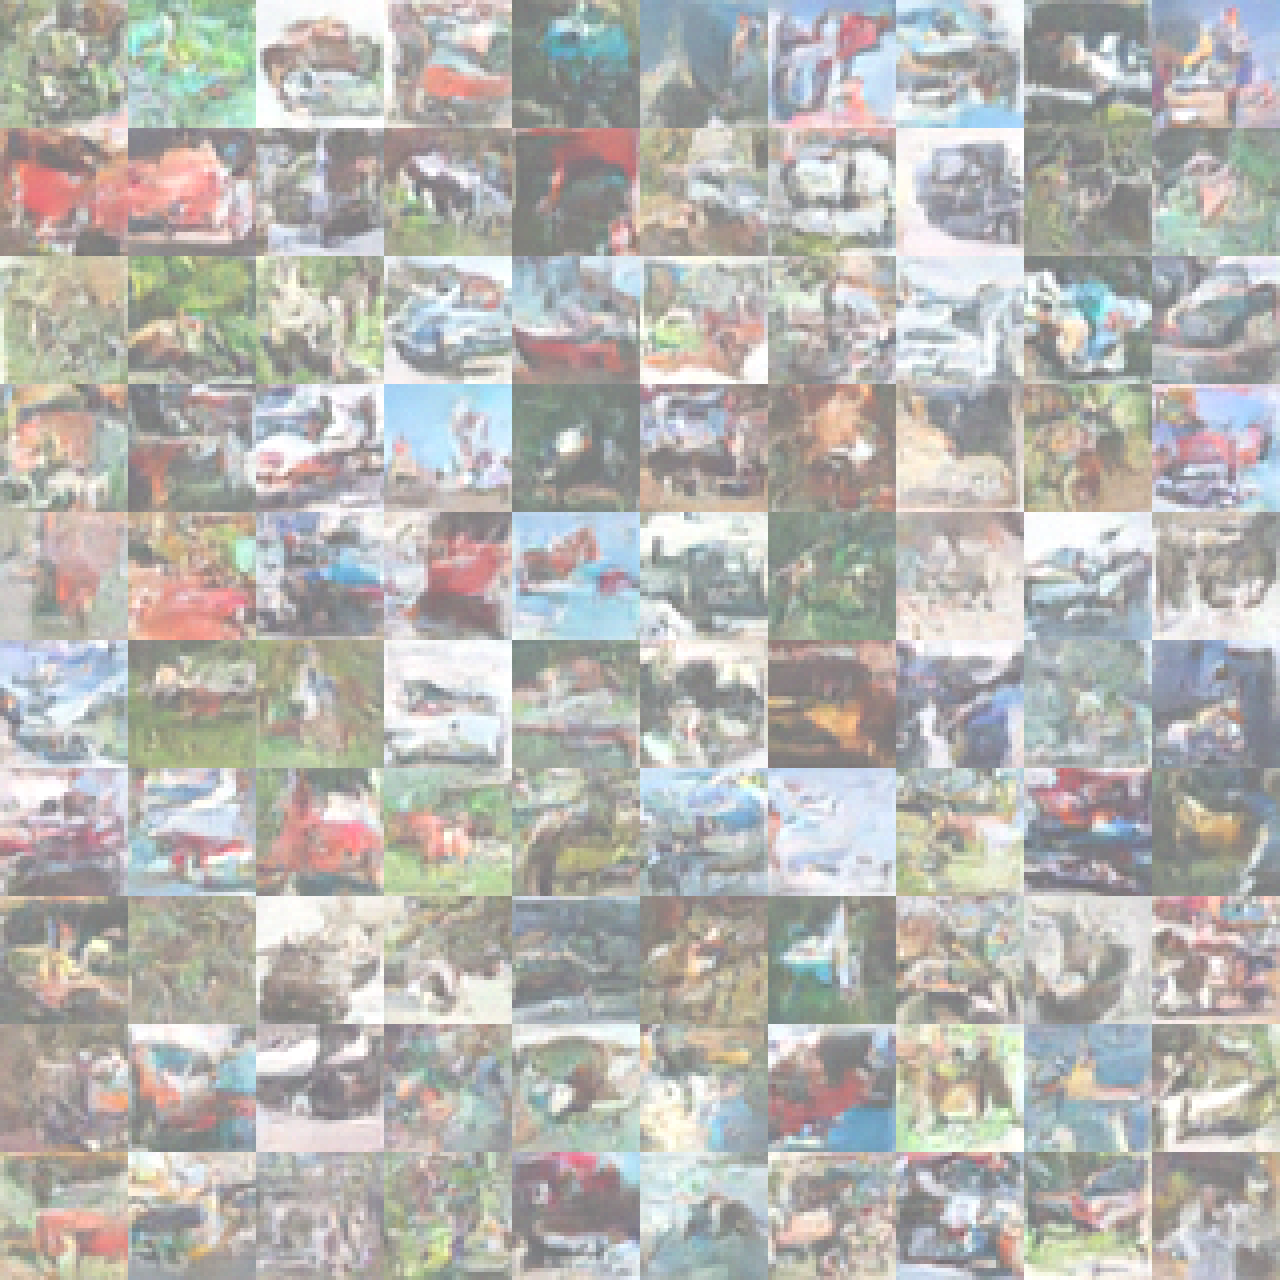

In [125]:
for i in range(100):
  ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))

image = Image.new('RGB', size=(32*10, 32*10))
for i, im in enumerate(ims):
  image.paste(im, ((i%10)*32, 32*(i//10)))
image.resize((32*4*10, 32*4*10), Image.NEAREST)

Installation

Generate and Save Samples

In [ ]:
!rm -r "/content/real"
!rm -r  "/content/fake"
!mkdir "/content/real"
!mkdir  "/content/fake"

rm: /content/real: No such file or directory
rm: /content/fake: No such file or directory
mkdir: /content: No such file or directory
mkdir: /content: No such file or directory


In [ ]:
import torchvision
from torchvision.utils import save_image
import os

output_fake_dir = "./content/fake/"
output_real_dir = "./content/real/"
os.makedirs(output_fake_dir, exist_ok=True)
os.makedirs(output_real_dir, exist_ok=True)

model = Unet(model_config).to(device)
model.load_state_dict(torch.load("./unit.pt"))


# generate 3000 samples
trans = transforms.ToTensor()
j = 0
for k in range(1):  # Genera 15 batch di 200 immagini (15 * 200 = 3000)
    x = torch.randn(100, 3, 32, 32).to(device)  # Inizia con rumore casuale
    print(f"Generazione batch {k + 1}")
    for i in range(n_steps):
        t = torch.tensor(n_steps - i - 1, dtype=torch.long).to(device)
        with torch.no_grad():
            pred_noise = model(x.float(), t.unsqueeze(0))
            x = p_xt(x, pred_noise, t.unsqueeze(0))
    for x0 in x:
        # Salva immagine generata
        save_image(x0.unsqueeze(0).cpu(), os.path.join(output_fake_dir, f"{j}.png"))

        # Estrai immagine reale dal dataset unito
        real_image, _ = full_dataset[j]  # Restituisce (immagine, etichetta)
        save_image(real_image, os.path.join(output_real_dir, f"{j}.png"))

        j += 1

/var/folders/kj/tp7hd0s96xzfxx912twysy4h0000gn/T/ipykernel_68138/3904327461.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./unit.pt"

Generazione batch 1


Compute the FID Score

In [128]:
from pytorch_fid import fid_score

# Specifica i percorsi delle cartelle contenenti le immagini
path_fake = './content/fake/'
path_real = './content/real/'

# Calcola il FID
fid_value = fid_score.calculate_fid_given_paths([path_fake, path_real], batch_size=50, device='cpu', dims=2048)

# Stampa il risultato
print(f"FID: {fid_value}")

 50%|█████     | 1/2 [00:18<00:18, 18.50s/it]


KeyboardInterrupt: 